# **Statistical Machine Learning: Exercise 4**

In [ ]:
import numpy as np
from cvxopt import matrix
import matplotlib.pyplot as plt
from prettytable import PrettyTable
%matplotlib inline

In [ ]:
!git clone https://github.com/julieeecious/sml-dataset.git

Cloning into 'sml-dataset'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 29 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [ ]:
ls sml-dataset/hw4

iris-pca.txt             mnist_small_test_out.txt  mnist_small_train_out.txt
mnist_small_test_in.txt  mnist_small_train_in.txt


# Task 1 Neural Networks

## Problem Statement

Given a dataset containing


*   a training set of labeled images
*   a test set of labeled images 
*   each image is of shape (784,), thus we reshape it to square (28, 28)



In [ ]:
train_x = np.loadtxt('sml-dataset/hw4/mnist_small_train_in.txt',delimiter=',',dtype=int)
train_y = np.loadtxt('sml-dataset/hw4/mnist_small_train_out.txt',delimiter=',',dtype=int)
test_x = np.loadtxt('sml-dataset/hw4/mnist_small_test_in.txt',delimiter=',',dtype=int)
test_y = np.loadtxt('sml-dataset/hw4/mnist_small_test_out.txt',delimiter=',',dtype=int)

In [ ]:
print(f'Number of training examples: {train_x.shape[0]}')
print(f'Number of testing examples: {test_x.shape[0]}')
print(f'Height/Width of each image: 28')
print(f'Each image is of size: (28,28)')
print(f'train_x shape: {train_x.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'test_x shape: {test_x.shape}')
print(f'test_y shape: {test_y.shape}')

Number of training examples: 6006
Number of testing examples: 1004
Height/Width of each image: 28
Each image is of size: (28,28)
train_x shape: (6006, 784)
train_y shape: (6006,)
test_x shape: (1004, 784)
test_y shape: (1004,)


## Data Preprocessing

A visualization of an example from the training set

<function matplotlib.pyplot.show>

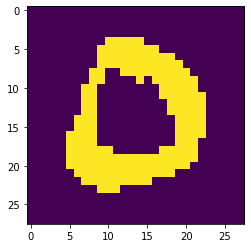

In [ ]:
plt.imshow(train_x[0].reshape((28,28)))
plt.show

We reshape the dataset and clip the margin of original image, in order to reduce the noise and the number of parameters that we need to compute.


In [ ]:
train_x2 = train_x.reshape((train_x.shape[0],28,28))
train_x2 = train_x2[:,4:-4,4:-4].reshape(-1,400)
test_x2 = test_x.reshape((test_x.shape[0],28,28))
test_x2 = test_x2[:,4:-4,4:-4].reshape(-1,400)

print(f'Each clipped image is of size: (20,20)')
print(f'train_x shape: {train_x2.shape}')
print(f'test_x shape: {test_x2.shape}')

Each clipped image is of size: (20,20)
train_x shape: (6006, 400)
test_x shape: (1004, 400)


A clipped image

<function matplotlib.pyplot.show>

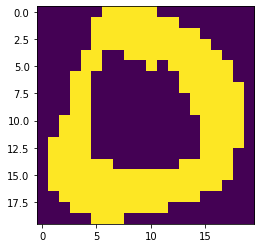

In [ ]:
plt.imshow(train_x2[0].reshape((20,20)))
plt.show

## Our Algorithm

**Hyperparameters**

After pre-processing, each image is of size 20px by 20px. Thus, we set the input layer size to 400. 

Since our dataset is a MNIST, there are in total 10 handwritten digit that we can to classify. Hence, the number of output is 10.

To begin with, we chose to set a hidden layer to 25 units, learning rate 0.01 and 900 epochs.

In [ ]:
input_layer_size = 400 
hidden_layer_size = 25 
num_label = 10 
learning_rate = 0.01
epoche = 900

Helper Functions

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
# Sigmoid Gradient
def sigmoid_grad(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [ ]:
assert sigmoid_grad(0) == 0.25

Regularized cost function

In [ ]:
def cost_function(X, y, nn_parameters, input_layer_size=400, hidden_layer_size=25, num_label=10, regularization_lambda=10):
    # parameter between input layer and hiden layer, size = 30 * 785, one column as bias 
    theta1 =  nn_parameters[:hidden_layer_size * (input_layer_size+1)].reshape((hidden_layer_size, input_layer_size+1))
    # parameter between hiden layer and output layer, size: 10 * 31, also one column as bias 
    theta2 =  nn_parameters[hidden_layer_size * (input_layer_size+1):].reshape((num_label, hidden_layer_size+1))
    num_train_data = X.shape[0]

    # compute loss
    X = np.c_[np.ones(num_train_data),X]  # (6006, 784) ->(6006, 785) add one column bias
    # represent y as one hot vector
    eye = np.eye(num_label)
    y = eye[y].reshape((-1,10))  # (6006,1) ->(6006,10)
    # forward propagation 
    a1 = X  # output of input layer (6006, 785)
    z2 = a1.dot(theta1.T) # input of hidden layer(6006, 25)
    a2 = sigmoid(z2) # output of hidden layer (6006, 25)
    a2 = np.c_[np.ones(num_train_data),a2]  # (6006,26) add one column as bias
    z3 = a2.dot(theta2.T) # input of output layer (6006,10)
    output = sigmoid(z3) # output of neural network
    # compute cross entropy 
    loss = np.sum(-y * np.log(output)- (1-y) * np.log(1-output)) / num_train_data
    # compute regularizition term
    regularizition_term = (np.sum(theta1[:,1:] ** 2) + np.sum(theta2[:,1:] ** 2)) * regularization_lambda/(2 * num_train_data)
    loss = loss + regularizition_term

    return np.round(loss,5)

Backpropagation

In [ ]:
def nn_gradient(X, y, nn_parameters, input_layer_size=400, hidden_layer_size=25, num_label=10, regularization_lambda=10):
    # parameter between input layer and hiden layer, size = 30 * 785, one column as bias 
    theta1 =  nn_parameters[:hidden_layer_size * (input_layer_size+1)].reshape((hidden_layer_size, input_layer_size+1))
    # parameter between hiden layer and output layer, size: 10 * 31, also one column as bias 
    theta2 =  nn_parameters[hidden_layer_size * (input_layer_size+1):].reshape((num_label, hidden_layer_size+1))
    
    theta1_grad = np.zeros_like(theta1)  # 30 * 785
    theta2_grad = np.zeros_like(theta2)  # 10 * 31
    
    num_train_data = X.shape[0]
    
    X = np.c_[np.ones(num_train_data),X]  # (6006, 784) ->(6006, 785) add one column as bias
    
    # represent y as one hot vector
    eye = np.eye(num_label)
    y = eye[y].reshape((-1,10))  # (6006,1) ->(6006,10)
 
    # backward propagation
    for i in range(num_train_data):
        z2 = theta1.dot(X[i,:]).reshape(1,-1) #(1,30)
        a2 = sigmoid(z2)  # (1,30)
        a2 = np.c_[1,a2]  # (1,31)
        z3 = theta2.dot(a2.T) #(10,1)
        output = sigmoid(z3).T  # (1,10)
        
        delta3 = output - y[i,:]
        delta2 = delta3.dot(theta2[:,1:]) * sigmoid_grad(z2) # (1,25)
        
        theta1_grad = theta1_grad + delta2.T.dot(X[i,:].reshape((1,-1)))
        theta2_grad = theta2_grad + delta3.T.dot(a2)
    
    # add regularization term to grad, as before we don't need add regularization on bias column
    theta1_grad[:,0] = theta1_grad[:,0] / num_train_data
    theta2_grad[:,0] = theta2_grad[:,0] / num_train_data

    theta1_grad[:,1:] = theta1_grad[:,1:] / num_train_data + (regularization_lambda / num_train_data) * theta1[:,1:] 
    theta2_grad[:,1:] = theta2_grad[:,1:] / num_train_data + (regularization_lambda / num_train_data) * theta2[:,1:]
    grad = np.concatenate((theta1_grad.reshape(-1),theta2_grad.reshape(-1)))

    return grad

Optimize

In [ ]:
def Adam_optimizer(parameters, parameters_grad, learning_rate):
    learning_rate = learning_rate
    b1 = 0.9  # first decay rate 
    b2 = 0.99  # second decay rate
    eps = 1e-8  # guarantee gradient is not zero
    
    m = np.zeros(np.shape(parameters_grad))  # first moment vector
    v = np.zeros(np.shape(parameters_grad))  # second moment vector
    
    m = b1 * m + (1 - b1) * parameters_grad  
    v = b2 * v + (1 - b2) * np.power(parameters_grad, 2)
    
    m_hat = m / (1 - b1)
    v_hat = v / (1 - b2)
    
    parameters_update = learning_rate * m_hat / (np.sqrt(v_hat) + eps)
    return parameters - parameters_update

Predict

In [ ]:
def predict(X,theta1,theta2):
    # theta1 (30 * 785), theta2 (10 ,31), X(6006, 784)
    X = np.c_[np.ones(X.shape[0]),X]
    
    hidden_layer = sigmoid(X.dot(theta1.T))  # (6006,30)
    hidden_layer = np.c_[np.ones(hidden_layer.shape[0]),hidden_layer]  # (6006,31)add one column bias
    output_pro = sigmoid(hidden_layer.dot(theta2.T))
    predict = np.argmax(output_pro,axis=1)
    return predict
    

Evaluate

In [ ]:
def evaluate(predict,truth):
    return np.round(1-np.mean(predict==truth.reshape(-1)),5)

Merge all functions into one model

In [ ]:
def model(x_train, y_train, x_test, y_test, epoch=900, learning_rate=0.01, print_stat=False, adaptive_lr=False):
  #  initialize all parameters 
  nn_parameters = np.random.rand(hidden_layer_size * (input_layer_size+1) + num_label * (hidden_layer_size+1))
  train_accuracy = []
  test_accuracy = []
  costs = []

  for i in range(epoch):
      grad = nn_gradient(x_train, y_train, nn_parameters)
      loss = cost_function(x_train, y_train, nn_parameters)
      costs.append(loss)

      # set adaptive learning rate, every 100 epoch learning rate minus 0.0015
      if adaptive_lr:
        if i % 100 ==0 and learning_rate > 0.0015:  
            learning_rate-=0.0015

      paras = Adam_optimizer(nn_parameters,grad,learning_rate)
      
      theta1 =  paras[:hidden_layer_size * (input_layer_size+1)].reshape((hidden_layer_size, input_layer_size+1))
      theta2 =  paras[hidden_layer_size * (input_layer_size+1):].reshape((num_label, hidden_layer_size+1))
      
      nn_parameters = np.concatenate((theta1.reshape(-1),theta2.reshape(-1)))
      
      train_predict = predict(x_train,theta1,theta2)
      train_acc = evaluate(train_predict,y_train)
      train_accuracy.append(train_acc)
      test_predict = predict(x_test,theta1,theta2)
      test_acc = evaluate(test_predict,y_test)
      test_accuracy.append(test_acc)

      if print_stat:
        if i % 100 == 0:
          print(f'After {i} iteration, cost: {loss}, train error: {train_acc}, test error: {test_acc}')
  
  d = {"costs": costs,
        "test_predict": test_predict,
        "train_predict": train_predict,      
        "learning rate": learning_rate,
        "num_iter": epoch,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy}
    
  print(f'train accuracy {(100 - 100*train_accuracy[-1])}%')  
  print(f'test accuracy {(100 - 100*test_accuracy[-1])}%')

  return d

In [ ]:
d = model(train_x2, train_y, test_x2, test_y, 900, 0.01, True, False)

After 0 iteration, cost: 116.14418, train error: 0.90127, test error: 0.90239
After 100 iteration, cost: 1.86179, train error: 0.17682, test error: 0.16036
After 200 iteration, cost: 1.43901, train error: 0.14269, test error: 0.13247
After 300 iteration, cost: 1.38653, train error: 0.13603, test error: 0.12749
After 400 iteration, cost: 1.38648, train error: 0.13603, test error: 0.12749
After 500 iteration, cost: 1.38644, train error: 0.13603, test error: 0.12749
After 600 iteration, cost: 1.38639, train error: 0.13603, test error: 0.12849
After 700 iteration, cost: 1.38635, train error: 0.13603, test error: 0.12849
After 800 iteration, cost: 1.3863, train error: 0.13603, test error: 0.12849
train accuracy 85.56400000000001%
test accuracy 86.65299999999999%


We can see clearly the cost is decreasing over iterations, which indicates the parameters are being learned.

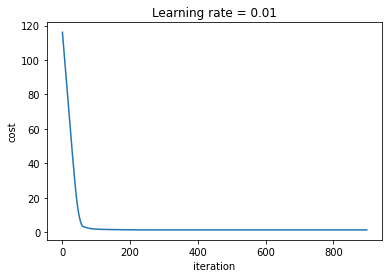

In [ ]:
plt.plot(np.squeeze(d['costs']))
plt.ylabel('cost')
plt.xlabel('iteration')
lr = 'Learning rate = ' + str(d['learning rate'])
plt.title(lr)
plt.show()

We can see that both training and test errors are decreasing over iteration, which means the accuracy is increasing.

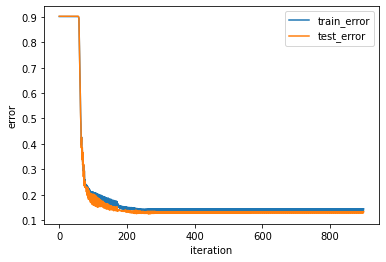

In [ ]:
plt.xlabel('iteration')
plt.ylabel('error')
plt.plot(np.squeeze(d['train_accuracy']), label='train_error')
plt.plot(np.squeeze(d['test_accuracy']), label='test_error')
plt.legend()

### Further Analysis

Choice of learning rate. In order for gradient descent to work, we have to choose the learning rate wisely. 

In [ ]:
learning_rates = [0.001, 0.0001]
models = {}

for i in learning_rates:
  print(f'learning rate is: {i}')
  models[str(i)] = model(train_x2, train_y, test_x2, test_y, 900, i, False, False)
  print('\n --------------- \n')


learning rate is: 0.001
train accuracy 87.712%
test accuracy 88.247%

 --------------- 

learning rate is: 0.0001
train accuracy 10.439999999999998%
test accuracy 10.259%

 --------------- 



Different learning rate result in different costs and prediction results. If the learning rate is too high, the cost may oscillate up and down. It may even diverge. 

A lower cost doesn't mean a better model. We have to check if there's possibly overfitting. It happens when the training accuracy is way higher than test accuracy. 

After trying different learning rate, the model with learning rate 0.001 has the best performance. 

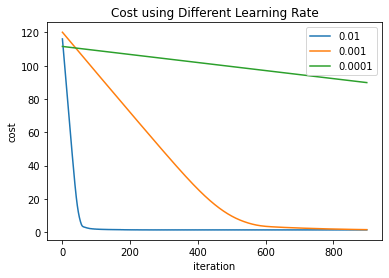

In [ ]:
plt.plot(np.squeeze(d['costs']), label=0.01)

for i in learning_rates:
  plt.plot(np.squeeze(models[str(i)]['costs']), label=str(i))

plt.title('Cost using Different Learning Rate')
plt.xlabel('iteration')
plt.ylabel('cost')
plt.legend()
plt.show()

We also try to adopt adpative learning rate to test the performance of such model. 

In [ ]:
adaptive_d = model(train_x2, train_y, test_x2, test_y, 900, 0.01, True, True)

After 0 iteration, cost: 124.96565, train error: 0.89777, test error: 0.8994
After 100 iteration, cost: 2.07903, train error: 0.19697, test error: 0.18127
After 200 iteration, cost: 1.35949, train error: 0.12821, test error: 0.11653
After 300 iteration, cost: 1.22255, train error: 0.11056, test error: 0.10657
After 400 iteration, cost: 1.16989, train error: 0.10423, test error: 0.10657
After 500 iteration, cost: 1.08825, train error: 0.09491, test error: 0.09363
After 600 iteration, cost: 0.99613, train error: 0.07742, test error: 0.08865
After 700 iteration, cost: 0.96394, train error: 0.07209, test error: 0.08566
After 800 iteration, cost: 0.95279, train error: 0.0701, test error: 0.08267
train accuracy 93.24%
test accuracy 91.932%


At last, we have reach an avergae accuracy 92.585%.

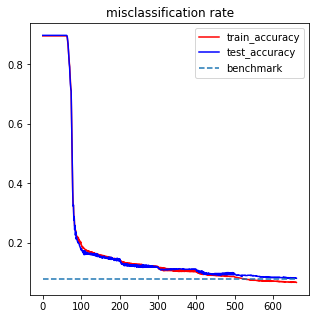

In [ ]:
plt.figure(figsize=((5,5)))
plt.plot(np.arange(len(train_accuracy)),np.array(train_accuracy),color='r')
plt.plot(np.arange(len(test_accuracy)),np.array(test_accuracy),color='b')
plt.plot(np.arange(len(test_accuracy)),0.08*np.ones_like(train_accuracy), linestyle='--')
plt.title('misclassification rate')
plt.legend(['train_accuracy','test_accuracy','benchmark'])

In [ ]:
# misclassification rate on test set
train_predict = predict(test_x2,theta1,theta2)
error = evaluate(train_predict,test_y)
error

0.0817

# Task 2 SVM

In [ ]:
# https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

In [ ]:
data = np.loadtxt('sml-dataset/hw4/iris-pca.txt')
data.shape

(100, 3)

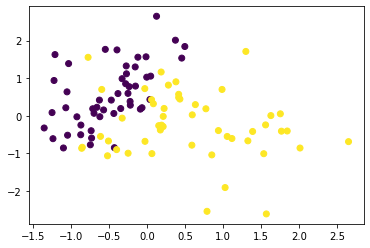

In [ ]:
plt.scatter(data[:,0],data[:,1],c=data[:,2])

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(data[:,[0,1]],data[:,2])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

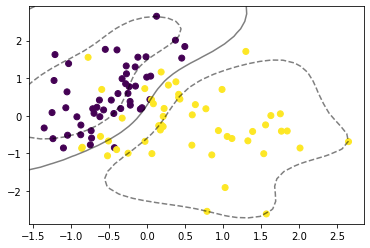

In [ ]:
plt.scatter(data[:,0],data[:,1],c=data[:,2])
plot_svc_decision_function(clf)

# Task 3 Gaussian Processes